In [56]:
import importlib
import modules
from collections import Counter
import numpy as np

importlib.reload(modules)

from modules import CA
import matplotlib.pyplot as plt
import cellpylib as cpl
from modules import triangulize_evolution
from modules import find_elem_jams
import scipy
import scipy.optimize as opt

from modules import initial_to_random_walk
from modules import run_model
from modules import jam_lifespans

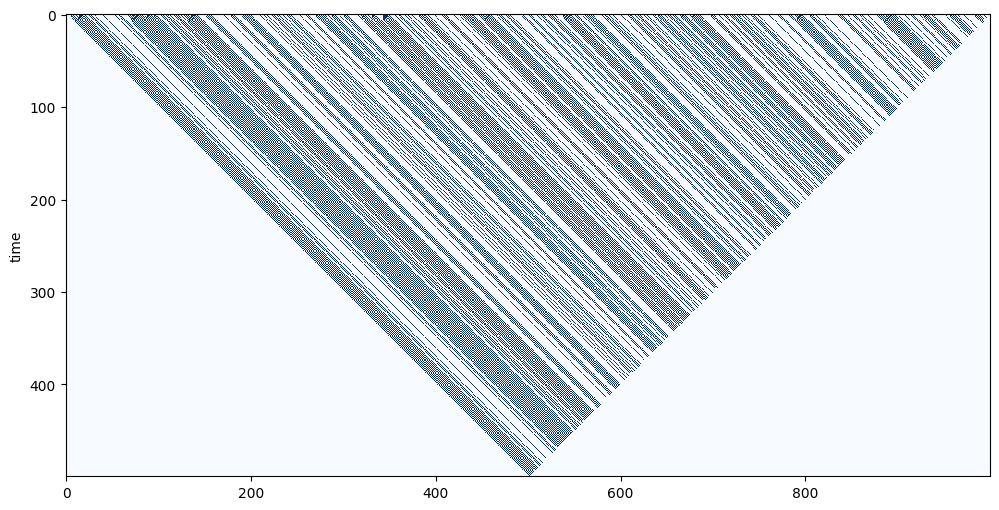

In [ ]:
ca_184 = CA()

p = 0.29
L = 1000
T = int(L / 2)
initial_state = ca_184.gen_initial_state_bernoulli(L, p)

cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
cellular_automaton_triangle = triangulize_evolution(cellular_automaton)

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(cellular_automaton_triangle, colormap='Blues')





In [ ]:
def calculate_jam_size(cellular_automaton_triangle):
    jam_size = {}
    automaton_shape = cellular_automaton_triangle.shape
    
    for row in range(automaton_shape[0]-1):  
        for column in range(automaton_shape[1]):
            state = cellular_automaton_triangle[row, column]
            new_state = cellular_automaton_triangle[row+1, column]

            original_jam_column = column + row

            if state == 1 and new_state == 1:
                if original_jam_column not in jam_size:
                    jam_size[original_jam_column] = 1
                else:
                    jam_size[original_jam_column] += 1

    return jam_size

def remove_short_jams(jam_sizes):
    jam_sizes_copy = jam_sizes.copy()
    previous_jam_size = 0
    removed_jams = []
    for key in jam_sizes_copy.keys():
        if jam_sizes_copy[key] <= previous_jam_size:
            removed_jams.append(key)
        else:
            previous_jam_size = jam_sizes_copy[key]

    for jam in removed_jams:
        jam_sizes_copy.pop(jam)

    return jam_sizes_copy, removed_jams

def merge_jams(jam_sizes):
    lists = sorted(jam_sizes.items()) # sorted by key, return a list of tuples

    jam, size = zip(*lists) # unpack a list of pairs into two tuples
    jam = np.array(jam)
    size = np.array(size)
    for index in range(len(jam)-1):
        if jam[index+1] == jam[index] + 1:
            size[index+1] += size[index]
            size[index] = 0
            
    sizes = [i for i in size if i != 0]


    return sizes

def run_simulation(N):
    final_jams_list = []
    for _ in range(N):
        ca_184 = CA()

        initial_state = ca_184.gen_initial_state_bernoulli(L, p)

        cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
        cellular_automaton_triangle = triangulize_evolution(cellular_automaton)

        
        jam_sizes = calculate_jam_size(cellular_automaton_triangle)
        jam_sizes_short, removed_jams = remove_short_jams(jam_sizes)
        final_jams = merge_jams(jam_sizes_short)
        final_jams_list.extend(final_jams)

    final_jams_counted = Counter(final_jams_list)

    return final_jams_counted

Specify jam area S, and plot jam area versus jam size s for different exponents alpha 

In [31]:

# Assuming your functions and parameters are defined here

def run_simulation_for_parameter_range(p_values, N):
    results = []

    for p in p_values:
        final_jams_list = []

        for _ in range(N):
            #Your existing simulation code
            ca_184 = CA()
            initial_state = ca_184.gen_initial_state_bernoulli(L, p)
            cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
            cellular_automaton_triangle = triangulize_evolution(cellular_automaton)
            jam_sizes = calculate_jam_size(cellular_automaton_triangle)
            jam_sizes_short, removed_jams = remove_short_jams(jam_sizes)
            final_jams = merge_jams(jam_sizes_short)
            final_jams_list.extend(final_jams)

        final_jams_counted = Counter(final_jams_list)
        results.append((p, final_jams_counted))

    return results

def fit_power_law(results):
    fitted_parameters = []

    for p, final_jams_counted in results:
        lists = sorted(final_jams_counted.items())
        x, y = zip(*lists)

        # Fit power-law function
        def func(x, a, b):
            return a * x ** -b

        popt, pcov = scipy.optimize.curve_fit(func, x, y, p0=[1, 0.5])
        a_optimal, b_optimal = popt

        fitted_parameters.append((p, b_optimal))

        # Plot individual fits
        x_fit = np.linspace(1, max(x), 1000)
        y_fit = func(x_fit, a_optimal, b_optimal)

        plt.figure(figsize=(12, 6))
        plt.title(f'Jam Sizes - p = {p}')
        plt.xlabel('Jam size')
        plt.ylabel('Number of jams')
        plt.plot(x, y, 'o', label='Data')
        plt.plot(x_fit, y_fit, label=f'Fit: b_optimal = {b_optimal:.4f}')
        plt.legend()
        plt.show()

    return fitted_parameters


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/carokluin/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/y2/4b7d_vjj5d70m77w1bxwqw640000gn/T/ipykernel_6010/2436190059.py", line 63, in <module>
    results = run_simulation_for_parameter_range(p_values, N)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/y2/4b7d_vjj5d70m77w1bxwqw640000gn/T/ipykernel_6010/2436190059.py", line 15, in run_simulation_for_parameter_range
    jam_sizes = calculate_jam_size(cellular_automaton_triangle)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/y2/4b7d_vjj5d70m77w1bxwqw640000gn/T/ipykernel_6010/2047798882.py", line -1, in calculate_jam_size
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/carokluin/Library/Python/3.11/

In [ ]:
#Parameters
L = 1000
T = int(L / 2)
N = 100
p_values = np.linspace(0.2, 0.8, 7)  # Adjust as needed

# Run simulations for different values of p
results = run_simulation_for_parameter_range(p_values, N)

# Fit power-law and collect fitted parameters
fitted_parameters = fit_power_law(results)

# Print the fitted parameters for each value of p
for p, b_optimal in fitted_parameters:
    print(f"For p = {p:.2f}, b_optimal = {b_optimal:.4f}")


In [33]:

# Your existing functions and parameters

def run_simulation_for_parameter_range(p_values, N):
    results = []

    for p in p_values:
        final_jams_list = []

        for _ in range(N):
            ca_184 = CA()
            initial_state = ca_184.gen_initial_state_bernoulli(L, p)
            cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
            cellular_automaton_triangle = triangulize_evolution(cellular_automaton)
            jam_sizes = calculate_jam_size(cellular_automaton_triangle)
            jam_sizes_short, removed_jams = remove_short_jams(jam_sizes)
            final_jams = merge_jams(jam_sizes_short)
            final_jams_list.extend(final_jams)

        final_jams_counted = Counter(final_jams_list)
        results.append((p, final_jams_counted))

    return results

def fit_power_law(results):
    fitted_parameters = []

    for p, final_jams_counted in results:
        lists = sorted(final_jams_counted.items())
        x, y = zip(*lists)

        # Fit power-law function
        def func(x, a, b):
            return a * x ** -b

        popt, pcov = scipy.optimize.curve_fit(func, x, y, p0=[1, 0.5])
        a_optimal, b_optimal = popt

        fitted_parameters.append((p, b_optimal))

    return fitted_parameters




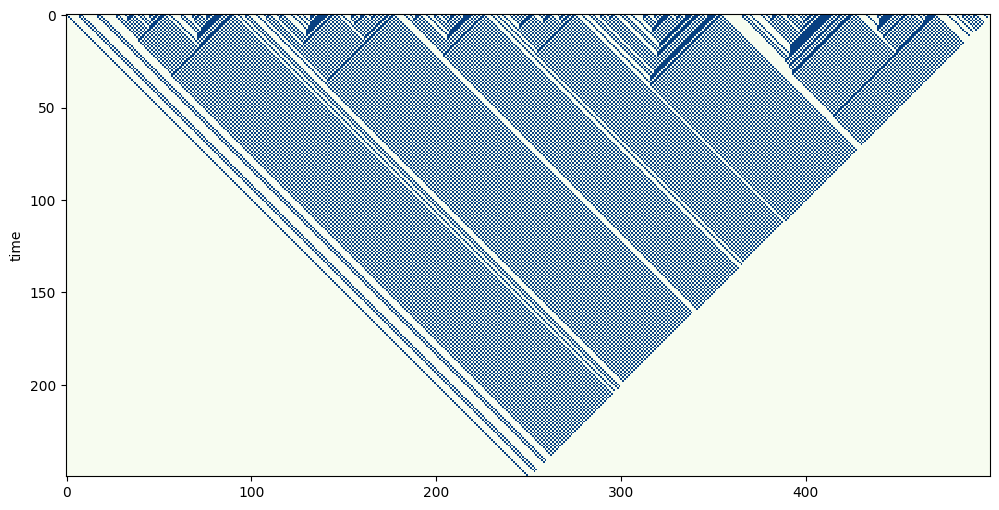

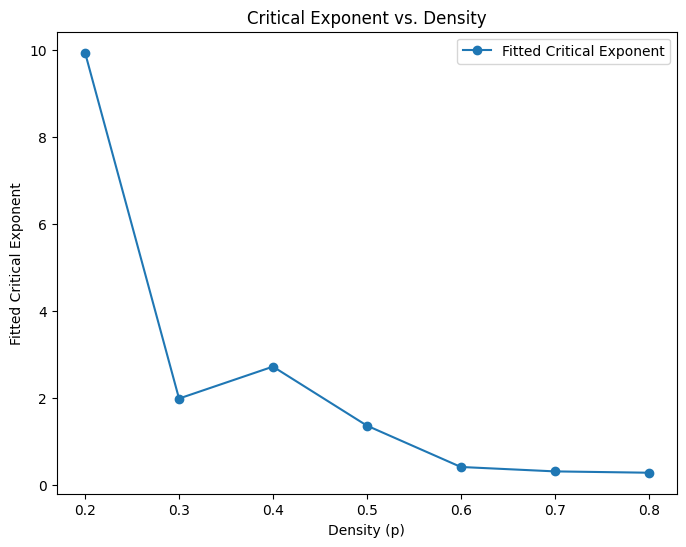

In [73]:

p = 0.5
L = 500
T = int(L / 2)
n_repetitions = 100
n_alpha = 2
p_values = np.linspace(0.2, 0.8, 7) # Adjust as needed
initial_state = ca_184.gen_initial_state_bernoulli(L, p)

# print(cellular_automaton)
cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
cellular_automaton = triangulize_evolution(cellular_automaton)

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(cellular_automaton, colormap='GnBu')

# Plot the random walk that is the initial state, go up for 1, down for 0
random_walk = initial_to_random_walk(initial_state)


def run_model_over_density(p_values, L, T, n_repetitions=100):
    """
    Function to run the model for different density values.

    Parameters:
    - p_values (list): List of float values representing different densities.
    - L (int): The length of the CA.
    - T (int): The number of timesteps.
    - n_repetitions (int): The number of times the model should be run for each density.

    Returns:
    - lifespan_counters (list): List of Counters with lifespans for each density.
    - jam_counters (list): List of Counters with jam sizes for each density.
    """
    lifespan_counters = []
    jam_counters_list = []  # Change to a list
    for p in p_values:
        total_lifespans = []
        total_jam_sizes = []

        for i in range(n_repetitions):
            ca_184 = CA()
            initial_state = ca_184.gen_initial_state_bernoulli(L, p)
            random_walk = initial_to_random_walk(initial_state)
            cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
            cellular_automaton = triangulize_evolution(cellular_automaton)

            lifespans = jam_lifespans(random_walk)
            total_lifespans += lifespans
            
            jams = find_elem_jams(cellular_automaton)
            jam_sizes = [jam[1] for jam in jams]
            total_jam_sizes += jam_sizes
        
        lifespan_counters.append(Counter(total_lifespans))
        jam_counters_list.append(Counter(total_jam_sizes))

    # Move this line outside the loop
    results = [(p, jam_counters) for p, jam_counters in zip(p_values, jam_counters_list)]

    return lifespan_counters, results


def fit_power_law(results):
    fitted_parameters = []

    for p, jam_counters in results:
        lists = sorted(jam_counters.items())
        x, y = zip(*lists)

        # Fit power-law function
        def func(x, a, b):
            return a * x ** -b

        popt, pcov = scipy.optimize.curve_fit(func, x, y, p0=[1, 0.5])
        a_optimal, b_optimal = popt

        fitted_parameters.append((p, b_optimal))

    return fitted_parameters

# Example usage
for _ in n_alpha:
    # Assuming you have already run_model_over_density and obtained results
    lifespan_counters, results_x = run_model_over_density(p_values, L, T, n_repetitions)

    # Fit power-law and get fitted parameters
    fitted_parameters = fit_power_law(results_x)

    # Extract density and critical exponent values
    densities, critical_exponents = zip(*fitted_parameters)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(densities, critical_exponents, 'o-', label='Fitted Critical Exponent')
plt.xlabel('Density (p)')
plt.ylabel('Fitted Critical Exponent')
plt.title('Critical Exponent vs. Density')
plt.legend()
plt.show()

In [69]:
print(densities, critical_exponents)

(0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000002, 0.8) (2.406919020330557, 5.947323750165751, 2.5641519245003455, 1.2508506050353747, 0.42751336057500683, 0.3164951003827631, 0.2894125382093905)


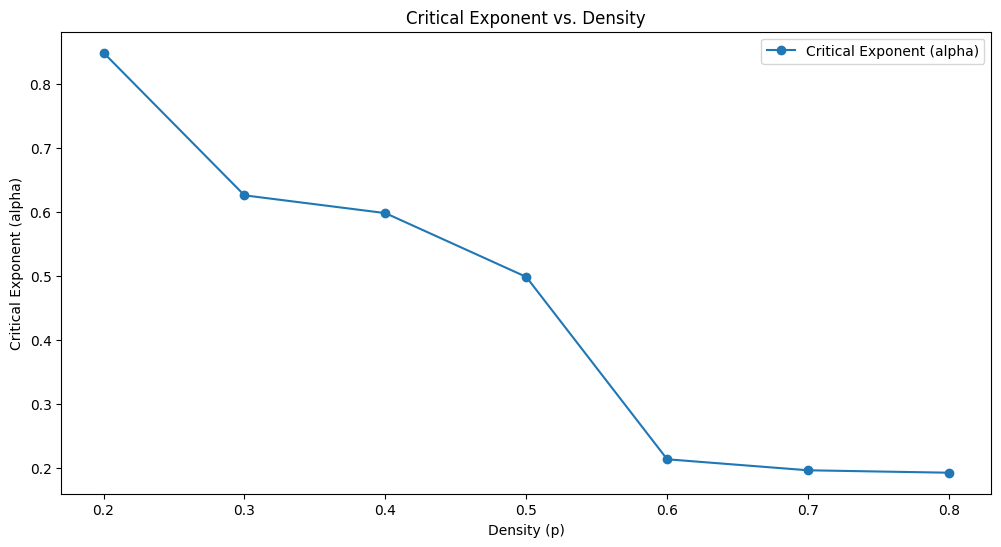

In [34]:
# Parameters
L = 1000
T = int(L / 2)
N = 100
p_values = np.linspace(0.2, 0.8, 7)  # Adjust as needed

# Run simulations for different values of p
results = run_simulation_for_parameter_range(p_values, N)

# Fit power-law and collect fitted parameters
fitted_parameters = fit_power_law(results)

# Extract critical exponent alpha from the fitted parameters
alpha_values = [b_optimal for _, b_optimal in fitted_parameters]
density_values = [p for p, _ in fitted_parameters]

# Plot the critical exponent alpha against the density
plt.figure(figsize=(12, 6))
plt.plot(density_values, alpha_values, 'o-', label='Critical Exponent (alpha)')
plt.xlabel('Density (p)')
plt.ylabel('Critical Exponent (alpha)')
plt.title('Critical Exponent vs. Density')
plt.legend()
plt.show()

In [41]:


def run_simulation_for_parameter_range(p_values, N):
    results = []

    for p in p_values:
        final_jams_list = []

        for _ in range(N):
            ca_184 = CA()
            initial_state = ca_184.gen_initial_state_bernoulli(L, p)
            cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
            cellular_automaton_triangle = triangulize_evolution(cellular_automaton)
            jam_sizes = calculate_jam_size(cellular_automaton_triangle)
            jam_sizes_short, removed_jams = remove_short_jams(jam_sizes)
            final_jams = merge_jams(jam_sizes_short)
            final_jams_list.extend(final_jams)

        final_jams_counted = Counter(final_jams_list)
        results.append((p, final_jams_counted))

    return results

def fit_power_law_desnity_critical_exponent(results):
    fitted_parameters = []

    for p, final_jams_counted in results:
        lists = sorted(final_jams_counted.items())
        x, y = zip(*lists)

        # Fit power-law function
        def func(x, a, b):
            return a * x ** -b

        popt, pcov = scipy.optimize.curve_fit(func, x, y, p0=[1, 0.5])
        a_optimal, b_optimal = popt

        fitted_parameters.append((p, b_optimal))

    return fitted_parameters



In [42]:
# Parameters
L = 1000
T = int(L / 2)
N = 10
p_values = np.linspace(0.2, 0.8, 7)  #Different density values

# Run simulations for different values of p
results = run_simulation_for_parameter_range(p_values, N)

# Fit power-law and collect fitted parameters
fitted_parameters = fit_power_law_desnity_critical_exponent(results)

# Extract critical exponent alpha from the fitted parameters
alpha_values = [b_optimal for _, b_optimal in fitted_parameters]
density_values = [p for p, _ in fitted_parameters]

# Fit a curve to the data (c=residual)
def curve_fit_func(x, a, b, c):
    return a * x ** b + c

popt_curve, _ = scipy.optimize.curve_fit(curve_fit_func, density_values, alpha_values)


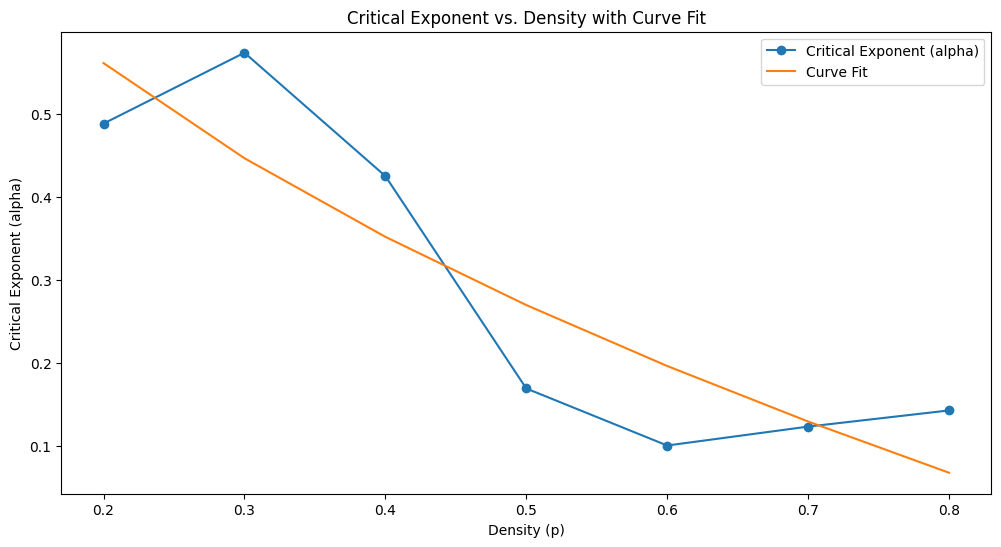

Curve Fit Parameters: [-1.18980075  0.44147545  1.14617584]


In [43]:
# Plot the critical exponent alpha against the density
plt.figure(figsize=(12, 6))
plt.plot(density_values, alpha_values, 'o-', label='Critical Exponent (alpha)')
plt.plot(density_values, curve_fit_func(density_values, *popt_curve), label='Curve Fit')
plt.xlabel('Density (p)')
plt.ylabel('Critical Exponent (alpha)')
plt.title('Critical Exponent vs. Density with Curve Fit')
plt.legend()
plt.show()

print("Curve Fit Parameters:", popt_curve)